# Create the corpus

In [ ]:
!pip install pymupdf
import fitz
import nltk.data
import re
nltk.download('punkt')
nltk.download('words')

     |████████████████████████████████| 6.0MB 4.2MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
corpus = ['set', 'value', 'description', 'time', 'flow', 'process', 'screen', 'check', 'gas', 'wafer', 'line', 'module', 'operation', 'equipment', 'pressure', 'parameter', 'command', 'rate', 'display', 'setting', 'manual', 'set value', 'description set', 'value description', 'flow rate', 'set whether', 'gas line', 'process module', 'accept command', 'auto check', 'value sec', 'sec description', 'see page', 'pm parameter', 'limit level', 'gas flow', 'time set', 'logging data', 'value disable', 'enable disable', 'set value description', 'value description set', 'description set whether', 'set value sec', 'value sec description', 'sec description set', 'set value disable', 'time set value', 'set whether accept', 'whether accept command']
len(corpus)


50

# Start building the model

In [ ]:
# Let's start building the model
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__

'2.3.0'

In [ ]:
def generate_dataset(corpus):  
    output = []
    for line in corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df          

In [ ]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset(corpus):
    pairs, df = generate_dataset(corpus)
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df

In [ ]:
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset(corpus)


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. 
p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

Dataset prepared with prefix and suffixes for teacher forcing technique


In [ ]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.iloc[60:70]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,input,output
60,<start> equ <end>,<start> ipment <end>
61,<start> equi <end>,<start> pment <end>
62,<start> equip <end>,<start> ment <end>
63,<start> equipm <end>,<start> ent <end>
64,<start> equipme <end>,<start> nt <end>
65,<start> equipmen <end>,<start> t <end>
66,<start> equipment <end>,<start> <end>
67,<start> pr <end>,<start> essure <end>
68,<start> pre <end>,<start> ssure <end>
69,<start> pres <end>,<start> sure <end>


In [ ]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Create the Bidirectional LSTM
encoder_lstm = Bidirectional(LSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = LSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 300)       49200       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 5, 256), (No 439296      embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
# Use 20% of our data for validation.
epochs = 100
history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 0s 18ms/step - loss: 0.1117 - sparse_categorical_accuracy: 0.9428 - val_loss: 1.3002 - val_sparse_categorical_accuracy: 0.8206
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.9397 - val_loss: 1.2974 - val_sparse_categorical_accuracy: 0.8206
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.9387 - val_loss: 1.2921 - val_sparse_categorical_accuracy: 0.8186
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.1061 - sparse_categorical_accuracy: 0.9423 - val_loss: 1.2899 - val_sparse_categorical_accuracy: 0.8186
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.1101 - sparse_categorical_accuracy: 0.9345 - val_loss: 1.2889 - val_sparse_categorical_accuracy: 0.8186
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.1092 - sparse_categorical_accuracy: 

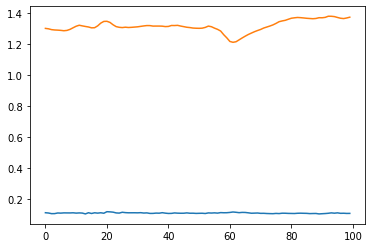

In [ ]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.show()

In [ ]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [ ]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [ ]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.


test = [
    'desc', 
    'fl',
    'ope',
    'value',
    'flow',
    'auto',
    'gas',
    'log'
]
  

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,desc,parameter
1,fl,n set whether
2,ope,ration
3,value,page
4,flow,
5,auto,cept command
6,gas,
7,log,parameter


In [ ]:
# This is to save the model for the web app to use for generation
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = inf_model.to_json()


with open("./sample_data/model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
inf_model.save_weights("./sample_data/model_num.h5")